In [1]:
#pip install imblearn

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from abc import ABC, abstractmethod
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay
from warnings import filterwarnings
import joblib
import os

In [3]:
class DataLoader(ABC):

    @abstractmethod
    def load_data(self):
        pass

    def _clean_data(self, df):
        """ENCAPSULATION: A protected method for internal cleaning steps."""
        df.columns = [col.lower().replace(' ', '_') for col in df.columns]

        print("Basic cleaning applied.")
        return df

class WineCleanCSVLoader(DataLoader):

    def __init__(self, filepath, target_col="quality", sep=','):
        self.filepath = filepath
        self.target_col = target_col
        self.sep = sep  # <-- store separator

    def load_data(self):
        df = pd.read_csv(self.filepath, sep=self.sep)
        print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns from {self.filepath}")
        df = self._clean_data(df)
        return df

In [4]:
loader = WineCleanCSVLoader(filepath="../data/processed/winequality_with_quality_category.csv", sep=',', target_col="quality_category")
wine_pro = loader.load_data()
wine_pro.head()

Loaded 1599 rows and 13 columns from ../data/processed/winequality_with_quality_category.csv
Basic cleaning applied.


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,quality_category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0,1.0


In [5]:
# Then split into X and y
X = wine_pro.drop(columns=["quality", "quality_category"])  # or keep "quality" if needed
y = wine_pro["quality_category"]

# Ensure no NaNs
mask = ~y.isna()
X = X[mask]
y = y[mask]

In [6]:
# Stratified split to maintain the same proportion of 'Good'/'Bad' quality in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("-" * 50)

X_train shape: (1256, 11)
X_test shape: (315, 11)
--------------------------------------------------


### Building a pipeline

In [7]:
mi_selector = SelectKBest(score_func=mutual_info_classif, k=10)  
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10)

In [8]:
#Preprocessor for MI
preprocessor_mi = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("feature_selection", mi_selector)
])

print(type(X_train), X_train.shape)
print(type(y_train), y_train[:10])

<class 'pandas.core.frame.DataFrame'> (1256, 11)
<class 'pandas.core.series.Series'> 587     1.0
986     2.0
946     2.0
596     1.0
898     2.0
1070    2.0
403     1.0
1412    1.0
826     2.0
1371    1.0
Name: quality_category, dtype: float64


In [9]:
#Preprocessor for RFE
preprocessor_rfe = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("feature_selection", rfe_selector)
])
print(type(X_train), X_train.shape)
print(type(y_train), y_train[:10])

<class 'pandas.core.frame.DataFrame'> (1256, 11)
<class 'pandas.core.series.Series'> 587     1.0
986     2.0
946     2.0
596     1.0
898     2.0
1070    2.0
403     1.0
1412    1.0
826     2.0
1371    1.0
Name: quality_category, dtype: float64


In [10]:
X_train_mi = preprocessor_mi.fit_transform(X_train, y_train)
X_train_rfe = preprocessor_rfe.fit_transform(X_train, y_train)

In [11]:
# Applying SMOTE only on preprocessed train set
smote = SMOTE(random_state=42)
X_train_mi_sm, y_train_mi_sm = smote.fit_resample(X_train_mi, y_train)
X_train_rfe_sm, y_train_rfe_sm = smote.fit_resample(X_train_rfe, y_train)

In [12]:
print("MI After SMOTE:", X_train_mi_sm.shape, y_train_mi_sm.shape)
print("RFE After SMOTE:", X_train_rfe_sm.shape, y_train_rfe_sm.shape)

MI After SMOTE: (3165, 10) (3165,)
RFE After SMOTE: (3165, 10) (3165,)


In [13]:
#Preprocessing test
# Transform test data using the already-fitted preprocessors
X_test_mi = preprocessor_mi.transform(X_test)
X_test_rfe = preprocessor_rfe.transform(X_test)

In [14]:
# Implement Concrete Strategies
# <<<<<<<<<<<Each model encapsulates its own initialization and logic. >>>>>>>>>>>>>>>>>>>>>>>>

class ModelStrategy(ABC):
    @abstractmethod
    def train(self, X, y):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass
    
    @abstractmethod
    def predict_proba(self, X):
        pass

# Concrete strategies
class LogisticRegressionStrategy(ModelStrategy):
    def __init__(self, **kwargs):
        self.model = LogisticRegression(multi_class='multinomial', **kwargs)
    
    def train(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

class RandomForestStrategy(ModelStrategy):
    def __init__(self, **kwargs):
        self.model = RandomForestClassifier(**kwargs)
    
    def train(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

class GradientBoostingStrategy(ModelStrategy):
    def __init__(self, **kwargs):
        self.model = GradientBoostingClassifier(**kwargs)
    
    def train(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

class SVCStrategy(ModelStrategy):
    def __init__(self, **kwargs):
        self.model = SVC(probability=True, **kwargs)
    
    def train(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

class KNNStrategy(ModelStrategy):
    def __init__(self, **kwargs):
        self.model = KNeighborsClassifier(**kwargs)
    
    def train(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

class RidgeClassifierStrategy(ModelStrategy):
    def __init__(self, **kwargs):
        self.model = RidgeClassifier(**kwargs)
    
    def train(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        # RidgeClassifier does not have predict_proba, so I use 
        # with decision function and softmax if needed
        from scipy.special import softmax
        return softmax(self.model.decision_function(X), axis=1)

In [15]:
models = {
    "Logistic Regression": LogisticRegressionStrategy(max_iter=1000, random_state=42),
    "Random Forest": RandomForestStrategy(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingStrategy(n_estimators=100, random_state=42),
    "SVC": SVCStrategy(kernel='rbf', random_state=42),
    "KNN": KNNStrategy(n_neighbors=5),
    "Ridge Classifier": RidgeClassifierStrategy(alpha=1.0)
}

In [16]:
# Train each model predict and store results with each feature selector
results_for_mi = {}
results_for_rfe = {}

for name, strategy in models.items():
    strategy.train(X_train_mi_sm, y_train_mi_sm)
    y_pred_mi = strategy.predict(X_test_mi)  
    acc_mi = accuracy_score(y_test, y_pred_mi)
    results_for_mi[name] = acc_mi
    print(f"{name} trained successfully!")
 
    strategy.train(X_train_rfe_sm, y_train_rfe_sm)
    y_pred_rfe = strategy.predict(X_test_rfe)
    acc_rfe = accuracy_score(y_test, y_pred_rfe)
    results_for_rfe[name] = acc_rfe

print("\n=== Results with Mutual Information Selected Features ===")
for name, score in results_for_mi.items():
    print(f"{name}: {score:.4f}")

print("\n=== Results with RFE Selected Features ===")
for name, score in results_for_rfe.items():
    print(f"{name}: {score:.4f}")

C:\Users\S P E C T R E\Desktop\Personal Projects\wine_quality_project\winequality\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\S P E C T R E\Desktop\Personal Projects\wine_quality_project\winequality\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression trained successfully!
Random Forest trained successfully!
Gradient Boosting trained successfully!
SVC trained successfully!
KNN trained successfully!
Ridge Classifier trained successfully!

=== Results with Mutual Information Selected Features ===
Logistic Regression: 0.4984
Random Forest: 0.8127
Gradient Boosting: 0.7587
SVC: 0.5556
KNN: 0.6730
Ridge Classifier: 0.4794

=== Results with RFE Selected Features ===
Logistic Regression: 0.5778
Random Forest: 0.8222
Gradient Boosting: 0.7524
SVC: 0.6667
KNN: 0.7016
Ridge Classifier: 0.5429


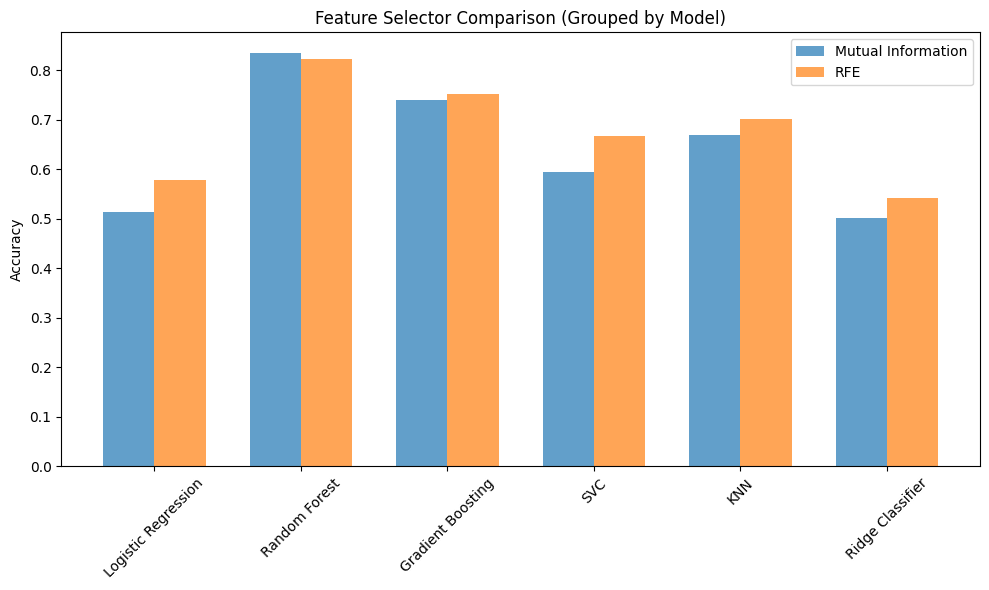

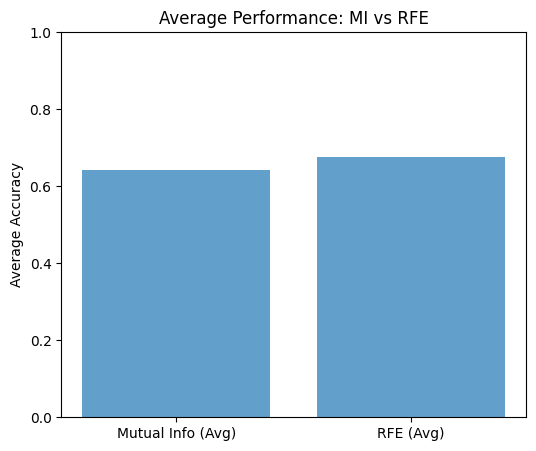

In [17]:
#Vizualisation for reports
# Your results
results_mi = {
    "Logistic Regression": 0.5143,
    "Random Forest": 0.8349,
    "Gradient Boosting": 0.7397,
    "SVC": 0.5937,
    "KNN": 0.6698,
    "Ridge Classifier": 0.5016
}

results_rfe = {
    "Logistic Regression": 0.5778,
    "Random Forest": 0.8222,
    "Gradient Boosting": 0.7524,
    "SVC": 0.6667,
    "KNN": 0.7016,
    "Ridge Classifier": 0.5429
}

model_names = list(results_mi.keys())
mi_scores = list(results_mi.values())
rfe_scores = list(results_rfe.values())

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, mi_scores, width, label='Mutual Information', alpha=0.7)
plt.bar(x + width/2, rfe_scores, width, label='RFE', alpha=0.7)

plt.xticks(x, models, rotation=45)
plt.ylabel("Accuracy")
plt.title("Feature Selector Comparison (Grouped by Model)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.bar(["Mutual Info (Avg)", "RFE (Avg)"], [np.mean(mi_scores), np.mean(rfe_scores)], alpha=0.7)
plt.ylabel("Average Accuracy")
plt.title("Average Performance: MI vs RFE")
plt.ylim(0,1)
plt.show()


In [18]:
#models = {
    #"Logistic Regression": LogisticRegressionStrategy(max_iter=1000, random_state=42),
    #"Random Forest": RandomForestStrategy(n_estimators=100, random_state=42),
    #"Gradient Boosting": GradientBoostingStrategy(n_estimators=100, random_state=42),
    #"SVC": SVCStrategy(kernel='rbf', random_state=42),
    #"KNN": KNNStrategy(n_neighbors=5),
    #"Ridge Classifier": RidgeClassifierStrategy(alpha=1.0)
#}


os.makedirs("../models", exist_ok=True)  # ensure folder exists

for name, strategy in models.items():
    filename = f"../models/{name.replace(' ', '_')}_RFE.joblib"
    joblib.dump(strategy.model, filename)
    print(f"{name} saved to {filename}")

Logistic Regression saved to ../models/Logistic_Regression_RFE.joblib
Random Forest saved to ../models/Random_Forest_RFE.joblib
Gradient Boosting saved to ../models/Gradient_Boosting_RFE.joblib
SVC saved to ../models/SVC_RFE.joblib
KNN saved to ../models/KNN_RFE.joblib
Ridge Classifier saved to ../models/Ridge_Classifier_RFE.joblib


#Choosng RFE because it performs better than MI in 5 out of 6 models

In [19]:
#Evaluation 

In [24]:
# Load trained models
rf_model   = joblib.load("../models/Random_Forest_RFE.joblib")
logreg_model = joblib.load("../models/Logistic_Regression_RFE.joblib")
gb_model   = joblib.load("../models/Gradient_Boosting_RFE.joblib")
svc_model  = joblib.load("../models/SVC_RFE.joblib")
knn_model  = joblib.load("../models/KNN_RFE.joblib")
ridge_model = joblib.load("../models/Ridge_Classifier_RFE.joblib")

models_loaded = {
    "Random Forest": rf_model,
    "Logistic Regression": logreg_model,
    "Gradient Boosting": gb_model,
    "SVC": svc_model,
    "KNN": knn_model,
    "Ridge Classifier": ridge_model
}

# Quick prediction check on a small slice of RFE-processed test data
for name, model in models_loaded.items():
    y_pred = model.predict(X_test_rfe[:10])  # first 10 samples just to check
    print(f"{name} prediction on first 10 test samples: {y_pred}")
    
print("\n===== FULL EVALUATION: MI Features =====")
for name, model in models_loaded.items():
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test_mi)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

print("\n===== FULL EVALUATION: RFE Features =====")
for name, model in models_loaded.items():
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test_rfe)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

Random Forest prediction on first 10 test samples: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Logistic Regression prediction on first 10 test samples: [0. 1. 0. 0. 1. 1. 0. 2. 1. 1.]
Gradient Boosting prediction on first 10 test samples: [0. 1. 1. 1. 1. 1. 1. 2. 1. 1.]
SVC prediction on first 10 test samples: [0. 1. 1. 1. 1. 1. 1. 2. 1. 1.]
KNN prediction on first 10 test samples: [0. 2. 1. 0. 1. 1. 1. 2. 1. 1.]
Ridge Classifier prediction on first 10 test samples: [0. 0. 0. 0. 1. 1. 1. 2. 1. 1.]

===== FULL EVALUATION: MI Features =====

--- Random Forest ---
Accuracy: 0.7619047619047619
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.84      0.88      0.86       264
         2.0       0.29      0.17      0.22        40

    accuracy                           0.76       315
   macro avg       0.38      0.35      0.36       315
weighted avg       0.74      0.76      0.75       315

Confusion M

#Some observation for my report 
Random Forest + RFE is clearly the best combo: 82% accuracy and better class balance for classes 0 and 2.

MI features generally favor class 1, because the smaller classes 0 and 2 are harder to predict.

Models like Ridge and Logistic Regression struggle on minority classes — classic case of imbalance.

Gradient Boosting is also strong, especially with RFE, showing better recall for class 2.

SVC and KNN have decent accuracy but tend to misclassify 0 and 2.

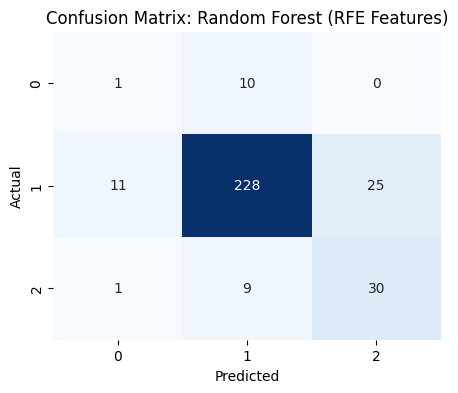

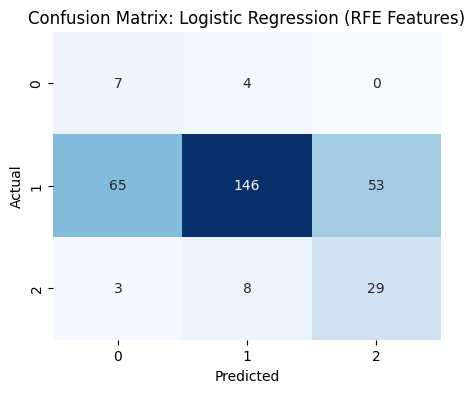

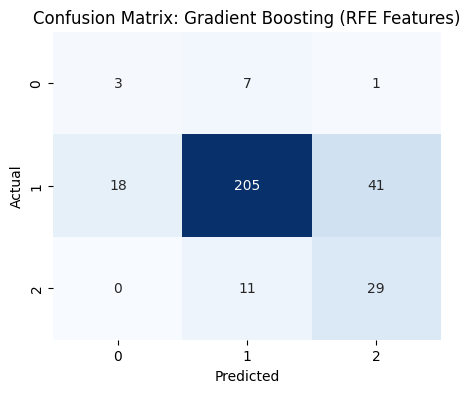

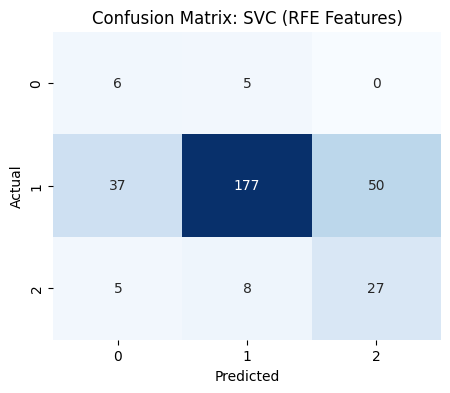

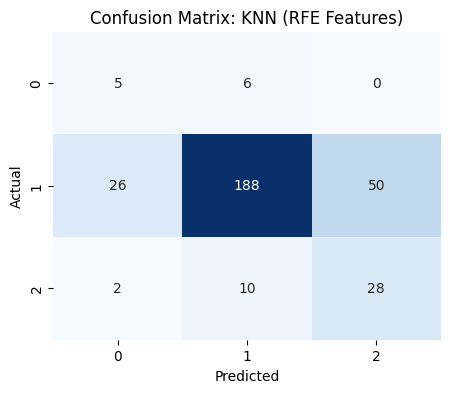

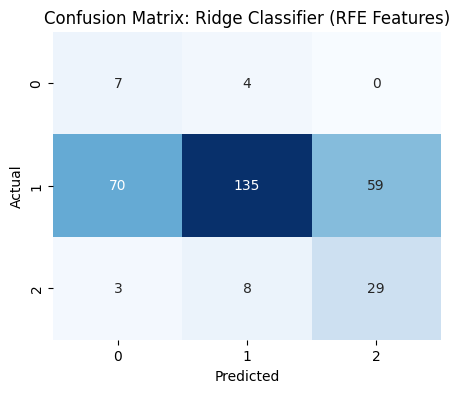

In [27]:
#visualizing the confusion matrices

models_loaded = {
    "Random Forest": rf_model,
    "Logistic Regression": logreg_model,
    "Gradient Boosting": gb_model,
    "SVC": svc_model,
    "KNN": knn_model,
    "Ridge Classifier": ridge_model
}

# Evaluate and plot confusion matrices
for name, model in models_loaded.items():
    y_pred = model.predict(X_test_rfe)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: {name} (RFE Features)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
#explain this 


=== Partial Dependence Plots for Class 0.0 ===


ValueError: Feature 'alcohol' not in feature_names

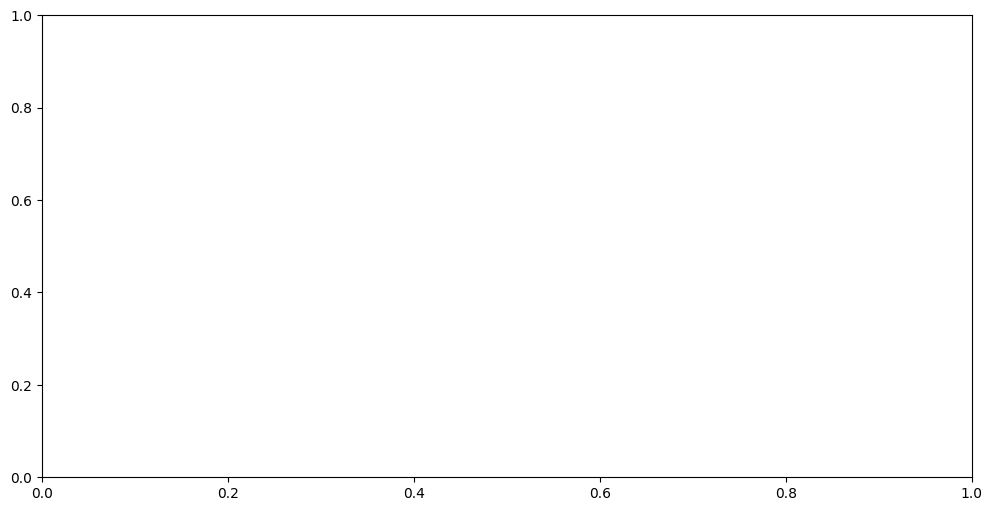

In [31]:
#visualize the relationship between a feature and all target classes (0,1,2)
# Choosing randonm forest because of strong performance on this project and interpretability with PDP
classes = sorted(y_test.unique())  # so i can get all classes in target
top_features = ["alcohol", "volatile_acidity", "citric_acid"]  # replace with your selected features

for target_class in classes:
    print(f"\n=== Partial Dependence Plots for Class {target_class} ===")
    
    fig, ax = plt.subplots(figsize=(12, 6))
    PartialDependenceDisplay.from_estimator(
        model,
        X_test_rfe,
        features=top_features,
        feature_names=feature_names,
        ax=ax,
        target=target_class
    )
    
    plt.suptitle(f"PDPs for Class {target_class} (RFE Features)")
    plt.tight_layout()
    plt.show()